In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
import math
import cv2
from scipy.optimize import minimize,fmin_l_bfgs_b
from torch.autograd import grad
use_cuda = 1
torchdeviceId = torch.device('cuda:0') if use_cuda else 'cpu'
torchdtype = torch.float32

In [3]:
path = "G:\\Host\\DataSet\\"

In [4]:
W = (torch.ones(10, 2401)/40/60).to(dtype=torchdtype, device=torchdeviceId)

In [5]:
# 求样本数
imgNum_list = []
for i in range(10):
    filePath = path + str(i) + "\\"
    nameList = os.listdir(filePath)
    imgNum_list.append(len(nameList))  #样本数
imgNum = sum(imgNum_list)

In [6]:
# 求x矩阵，大小为(imgNum,2401)，每一行为[1,img(0,0),img(0,1),...,img(39,59)]
X = torch.ones(imgNum, 2401).to(dtype=torchdtype, device=torchdeviceId)
for i in range(10):
    filePath = path + str(i) + "\\"
    nameList = os.listdir(filePath)
    for j in range(len(nameList)):
        img = cv2.imread(filePath + nameList[j])
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        thresh,threshold=cv2.threshold(gray,80,255,cv2.THRESH_BINARY)
        Temp = (threshold.reshape(1,40*60))/255
        
        index = sum(imgNum_list[0:i]) + j
        X[index, 1:] = torch.from_numpy(Temp)

In [7]:
# 求y矩阵，大小为(imgNum,10)，每一行为(y0,y1,...,y9)
WX = torch.matmul(W, X.T)
Y = torch.exp(WX).T
Y = Y / Y.sum(dim=1).reshape(imgNum,1).repeat(1,10)

In [8]:
# 求t矩阵，大小为(imgNum,10),如每一行为(1,0,...,0)
T = torch.zeros(imgNum,10).to(dtype=torchdtype, device=torchdeviceId)
for i in range(10):
    T[sum(imgNum_list[0:i]):sum(imgNum_list[0:i+1]),i] = 1

In [9]:
# 求损失函数Ew
Ew = (-T*torch.log(Y)).sum()

In [10]:
# 求梯度矩阵g，大小为(10,2401)，如第一行为对ΔE(w0)
G = torch.matmul(X.T,(Y - T))

In [11]:
# 求Hessian矩阵h，大小为(10,10)，其中h(i,j)表示E(w)对wi求导再对wj求导
FF = torch.matmul(X, X.T)
FF = torch.diagonal(FF).repeat(10,1)
H = torch.matmul(Y.T*FF, Y) - torch.ones(10,10).to(dtype=torchdtype, device=torchdeviceId)

In [12]:
# 求y矩阵，大小为(imgNum,10)，每一行为(y0,y1,...,y9)
def GetY(W,X,imgNum):
    WX = torch.matmul(W, X.T)
    Y = torch.exp(WX).T
    Y = Y / Y.sum(dim=1).reshape(imgNum,1).repeat(1,10)
    return Y
    
# 求t矩阵，大小为(imgNum,10),如每一行为(1,0,...,0)
def GetT(imgNum, imgNum_list):
    T = torch.zeros(imgNum,10).to(dtype=torchdtype, device=torchdeviceId)
    for i in range(10):
        T[sum(imgNum_list[0:i]):sum(imgNum_list[0:i+1]),i] = 1
    return T

# 求损失函数值Ew
def GetEw(Y,T):
    Ew = (-T*torch.log(Y)).sum() 
    return Ew

# 求梯度矩阵g，大小为(10,2401)，如第一行为对ΔE(w0)
def GetGrad(X,T,Y):
    G = torch.matmul(X.T,(Y - T))
    return G

# 求Hessian矩阵h，大小为(10,10)，其中h(i,j)表示E(w)对wi求导再对wj求导
def GetHessian(X,Y):
    FF = torch.matmul(X, X.T)
    FF = torch.diagonal(FF).repeat(10,1)
    H = torch.matmul(Y.T*FF, Y) - torch.ones(10,10).to(dtype=torchdtype, device=torchdeviceId)
    return H

In [71]:
max_iter = 500000
Ew_min = 1
Ew_vec = []
k = 1

for i in range(max_iter):
    Y = GetY(W, X, imgNum)
    T = GetT(imgNum, imgNum_list)
    Ew = GetEw(Y, T)
    Ew_vec.append(Ew.cpu())
    if(Ew<Ew_min):
        break
        
    Grad = GetGrad(X, T, Y)
    Hessian = GetHessian(X, Y)
    Hessian = Hessian + k*torch.eye(10,10).to(dtype=torchdtype, device=torchdeviceId)*torch.diagonal(Hessian).max()
    W = W - torch.matmul(Hessian.inverse(), Grad.T)

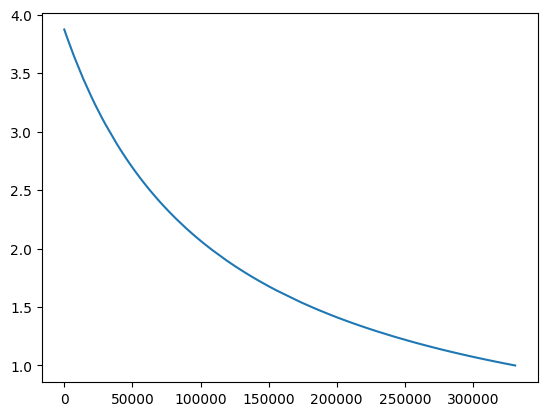

In [72]:
x = np.arange(len(Ew_vec))
y = np.array(Ew_vec)
plt.plot(x,y)

In [76]:
w = np.array(W.cpu())
np.savetxt("w08310334.txt", w, fmt="%lf")